# NLP Twitter Disasters

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

rc = {"axes.spines.left" : True,
      "axes.spines.right" : False,
      "axes.spines.bottom" : True,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "figure.subplot.hspace" : 0.7,
    "figure.titleweight" : "bold",
    "axes.titleweight" : "bold"}
plt.rcParams.update(rc)

In [4]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

train.head().style.set_properties()

,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
print(f'Training set: {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test set: {test.shape[0]} rows and {test.shape[1]} columns.')

Training set: 7613 rows and 5 columns.
Test set: 3263 rows and 4 columns.


> The additional column in our training set is of course the target column.

In [6]:
train[train["target"]==0].head().style.set_properties()

,id,keyword,location,text,target
15,23,nan,nan,What's up man?,0
16,24,nan,nan,I love fruits,0
17,25,nan,nan,Summer is lovely,0
18,26,nan,nan,My car is so fast,0
19,28,nan,nan,What a goooooooaaaaaal!!!!!!,0


# Cleaning

In [7]:
df = pd.concat([train, test])
df.shape

(10876, 5)

In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

Our target is either 0 or 1, indicating a relationship with disaster tweet. 

Percentage of disaster tweets: 0.4296597924602653


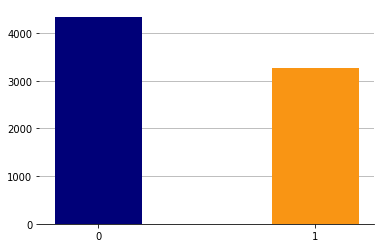

In [9]:
dt = train.target.value_counts()

fig, ax = plt.subplots()
ax.grid(axis='y', zorder=0)
ax.bar([str(x) for x in dt.index.values], dt.values, width = 0.4, zorder=3, color=["#000078", "#f99514"])
ax.spines['left'].set_visible(False)

print("Percentage of disaster tweets:", 
      train.target.value_counts()[1]/(train.target.value_counts()[0]+ train.target.value_counts()[1]))

# EDA

In [10]:
def tweet_length(text):
    return len(text)

# Get number of characters of all tweets
train["length"] = train["text"].apply(tweet_length)

Text(0.5, 1.0, 'Disaster vs Non-disaster tweets')

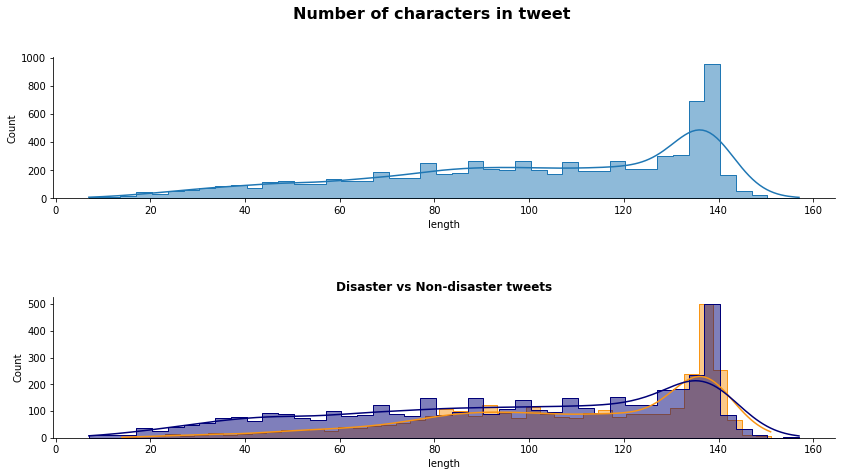

In [11]:
fig, axs = plt.subplots(2, figsize=(14,7))

sns.histplot(train["length"], kde=True, ax=axs[0], element="step", bins=45)

sns.histplot(train[train["target"] == 1]["length"], kde=True, ax=axs[1], element="step", color="#f99514", bins=45)
sns.histplot(train[train["target"] == 0]["length"], kde=True, ax=axs[1], element="step", color="#000078", bins=45)

fig.suptitle('Number of characters in tweet', fontsize=16)
axs[1].set_title('Disaster vs Non-disaster tweets')

### Feature: Location
Locations appears to be a user input rather than automatically created, thus resulting in a lot of unique values. Since location possess high cardionality, it will not be a useful feature. 

In [12]:
train["location"].dropna().head()

31                       Birmingham
32    Est. September 2012 - Bristol
33                           AFRICA
34                 Philadelphia, PA
35                       London, UK
Name: location, dtype: object

In [13]:
print(f'Location: # of uniques:\n Train {train["location"].nunique()} \n Test {test["location"].nunique()}')

Location: # of uniques:
 Train 3341 
 Test 1602


In [14]:
#Dropping location column
train = train.drop(["location"], axis=1)

In [15]:
print(f'Keyword: # of uniques:\n Train {train["keyword"].nunique()} \n Test {test["keyword"].nunique()}')

Keyword: # of uniques:
 Train 221 
 Test 221


<AxesSubplot:xlabel='count', ylabel='keyword'>

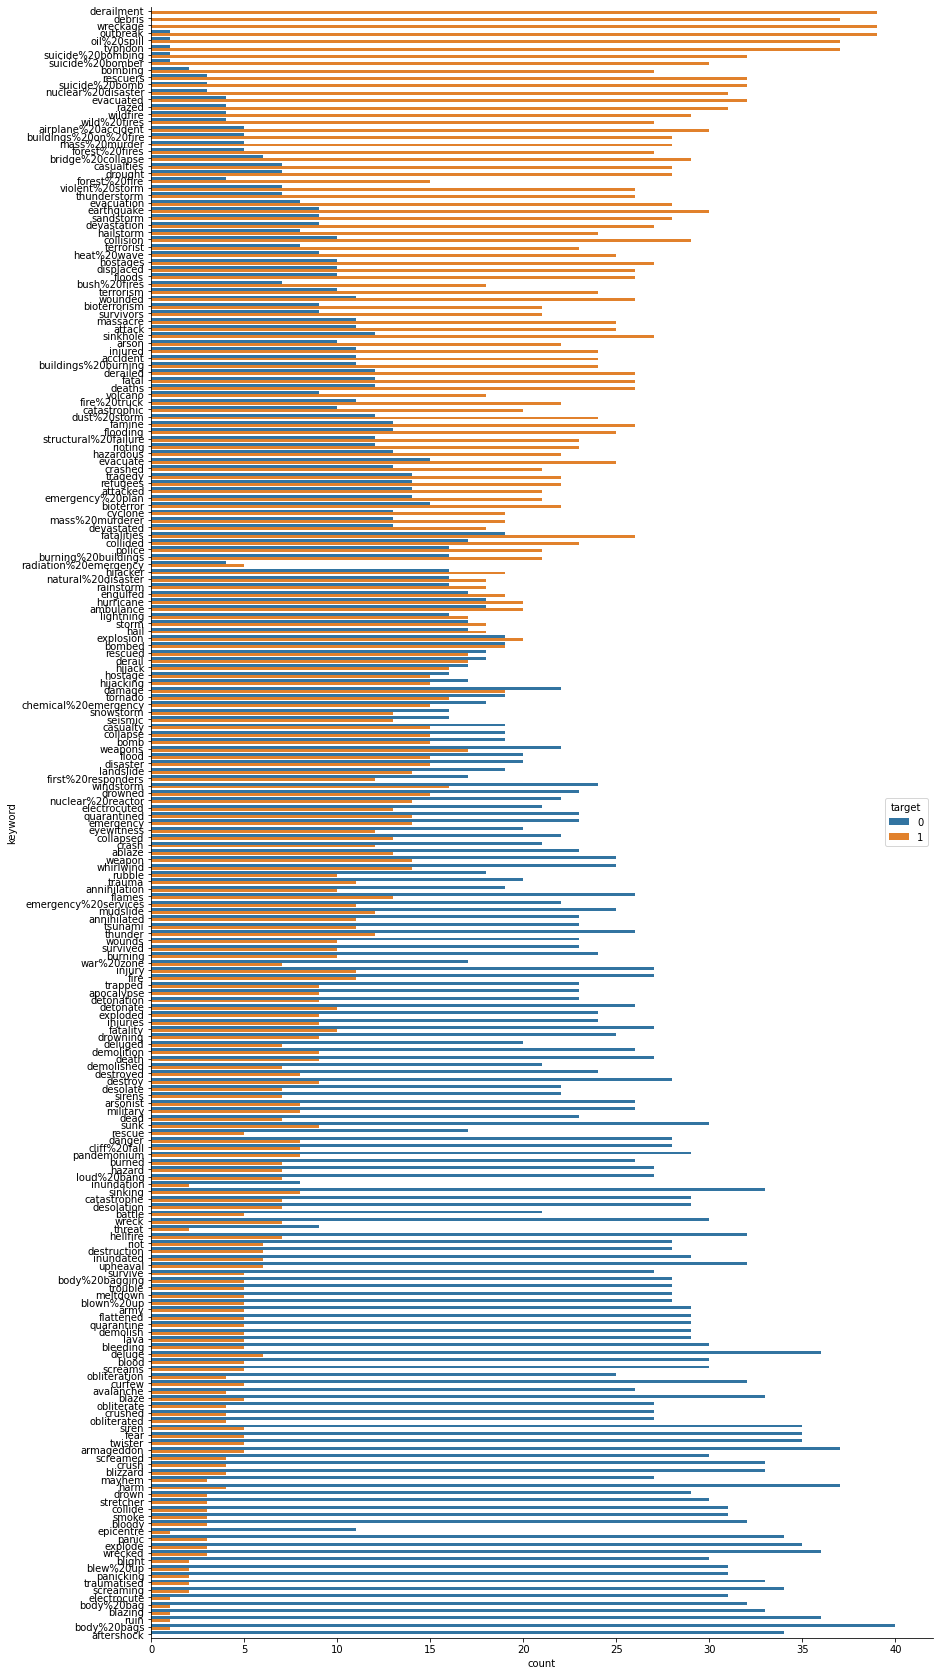

In [16]:
train['target_mean'] = train.groupby("keyword")["target"].transform("mean")

fig, axs = plt.subplots(figsize=(14,30))

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

# Cleaning

In [17]:
from spellchecker import SpellChecker

spell = SpellChecker()
def spell_correction(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#train["clean"] = train["text"].apply(lambda x : spell_correction(x))

In [18]:
def clean_text(text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [19]:
train["clean"] =  clean_text(train["text"])

C:\Users\andre\AppData\Local\Temp\ipykernel_4176\2857005956.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"\#","") # replaces hashtags
C:\Users\andre\AppData\Local\Temp\ipykernel_4176\2857005956.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"http\S+","URL")  # remove URL addresses
C:\Users\andre\AppData\Local\Temp\ipykernel_4176\2857005956.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
C:\Users\andre\AppData\Local\Temp\ipykernel_4176\2857005956.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace("\s{2,}", " ")


In [20]:
train.head()

,id,keyword,text,target,length,target_mean,clean
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,NaN,our deeds are the reason of this earthquake ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,38,NaN,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,133,NaN,all residents asked to 'shelter in place' are ...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,65,NaN,13 000 people receive wildfires evacuation ord...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,NaN,just got sent this photo from ruby alaska as s...


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['target'])

train['target_encoded'] = le.transform(train['target'])
train.head()

,id,keyword,text,target,length,target_mean,clean,target_encoded
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,38,NaN,forest fire near la ronge sask canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1,133,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,65,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,NaN,just got sent this photo from ruby alaska as s...,1


In [23]:
from sklearn.model_selection import train_test_split

x = train['clean']
y = train['target_encoded']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()